In [152]:
import pandas as pd
import numpy as np
import pylab as plt
from IPython import display
import seaborn as sns
sns.set()
import matplotlib
from pylab import rcParams
import itertools 
import time 
from random import seed
from random import random
from matplotlib import pyplot
# 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, auc
#from skimage.io import imread
from PIL import Image

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#Reading data, calendar and sell_prices
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

## Files: 

In [3]:
print(f"Train set shape:{train.shape}")
train.head()

Train set shape:(33126, 8)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
print(f"Test set shape:{test.shape}")
test.head()

Test set shape:(10982, 5)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
image_name                       10982 non-null object
patient_id                       10982 non-null object
sex                              10982 non-null object
age_approx                       10982 non-null float64
anatom_site_general_challenge    10631 non-null object
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


Note there are 351 missing values in `anatom_site_general_challenge`

In [7]:
print("The task!!:")
sample_submission.head(3)

The task!!:


,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0


## Looking at the distinct columns

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
image_name                       33126 non-null object
patient_id                       33126 non-null object
sex                              33061 non-null object
age_approx                       33058 non-null float64
anatom_site_general_challenge    32599 non-null object
diagnosis                        33126 non-null object
benign_malignant                 33126 non-null object
target                           33126 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [8]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [9]:
print("The target is highly biased against negatives:")
train.target.value_counts()

The target is highly biased against negatives:


0    32542
1      584
Name: target, dtype: int64

In [10]:
print(f"There is only {584.0/32542*100:.2f}% of the pictures with cancer diagnosis!")

There is only 1.79% of the pictures with cancer diagnosis!


In [11]:
# List of image_names diagnosed malignant:
malignant_image_names = train[train.benign_malignant == "malignant"].image_name.to_list()
print("This a list of image_names diagnosed malignant:")
print(f"{malignant_image_names[:5]}" )

This a list of image_names diagnosed malignant:
['ISIC_0149568', 'ISIC_0188432', 'ISIC_0207268', 'ISIC_0232101', 'ISIC_0247330']


In [13]:
train.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

#### Compute missing values:

In [14]:
missing_vals_train = train.isnull().sum() 
print(f"Total number entries train: {train.shape[0]}")
print(f"Missing values:")
missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

Total number entries train: 33126
Missing values:


anatom_site_general_challenge    527
age_approx                        68
sex                               65
dtype: int64

In [17]:
missing_vals_test = test.isnull().sum() 
print(f"Total number entries: {test.shape[0]}")
print(f"Missing values:")
missing_vals_test[missing_vals_test > 0].sort_values(ascending=False)

Total number entries: 10982
Missing values:


anatom_site_general_challenge    351
dtype: int64

In [18]:
print('Percentage of missing anatom_site_general for,\nTrain and test set:')
print(f"{527.0/train.shape[0]*100:0.2f}%\t{351.0/test.shape[0]*100:0.2f}%")

Percentage of missing anatom_site_general for,
Train and test set:
1.59%	3.20%


## Patient Id Counts

In [19]:
patient_counts_train = train.patient_id.value_counts()
patient_counts_test = test.patient_id.value_counts()
print(f"Distinct ids in the train set: {len(patient_counts_train)}")
print(f"Maximum number of images per id (train set): {patient_counts_train.max()}.")
print(f"Distinct ids in the test set: {len(patient_counts_test)}")
print(f"Maximum number of images per id (test set): {patient_counts_test.max()}.")

Distinct ids in the train set: 2056
Maximum number of images per id (train set): 115.
Distinct ids in the test set: 690
Maximum number of images per id (test set): 240.


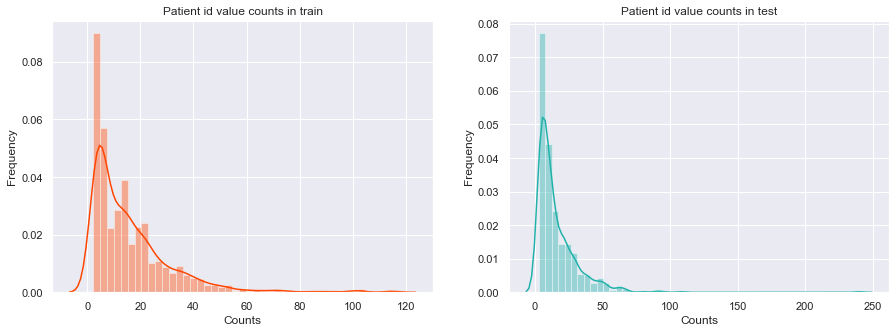

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.distplot(patient_counts_train, ax=ax[0], color="orangered", kde=True);
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Patient id value counts in train");

sns.distplot(patient_counts_test, ax=ax[1], color="lightseagreen", kde=True);
ax[1].set_xlabel("Counts")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Patient id value counts in test");

#sns.boxplot(patient_counts_train, ax=ax[1,0], color="orangered");
#ax[1,0].set_xlim(0, 250)
#sns.boxplot(patient_counts_test, ax=ax[1,1], color="lightseagreen");
#ax[1,1].set_xlim(0, 250);

In [21]:
#help(sns.boxplot)
patient_counts_train

IP_4382720    115
IP_7279968    115
IP_4479736    115
IP_4938382    115
IP_0656529    114
             ... 
IP_6739626      3
IP_5188822      3
IP_7167373      3
IP_3576583      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [22]:
print("Min patient image counts for train, test:")
np.quantile(patient_counts_train, 0.0),np.quantile(patient_counts_test, 0.0)

Min patient image counts for train, test:


(2.0, 3.0)

In [23]:
print("Median patient image counts for train, test:")
np.quantile(patient_counts_train, 1/2.0),np.quantile(patient_counts_test, 0.5)

Median patient image counts for train, test:


(12.0, 10.0)

In [24]:
print("Q3 patient image counts for train, test:")
np.quantile(patient_counts_train, 3/4),np.quantile(patient_counts_test, 3/4)

Q3 patient image counts for train, test:


(22.0, 21.0)

In [42]:
print("Max patient image counts for train, test:")
np.quantile(patient_counts_train, 1),np.quantile(patient_counts_test, 1)

Max patient image counts for train, test:


(115, 240)

Note there is an outlier in the test set with 240 pictures !

### Extract gender per patient

In [27]:
#Here we must apply a lambda since  
train.groupby("patient_id").sex.unique()

patient_id
IP_0001230    [female]
IP_0019713      [male]
IP_0036322      [male]
IP_0038436      [male]
IP_0038545    [female]
                ...   
IP_9989332    [female]
IP_9992027    [female]
IP_9995095      [male]
IP_9996429      [male]
IP_9997715    [female]
Name: sex, Length: 2056, dtype: object

In [33]:
#Create a series with patient_id as index and gender values for train and test
patient_gender_train = train.groupby("patient_id").sex.unique().apply(lambda l: l[0])
patient_gender_test = test.groupby("patient_id").sex.unique().apply(lambda l: l[0])
#Convert series into train_patients and test_patients dataframes 
train_patients = pd.DataFrame(index=patient_gender_train.index.values, 
                              data=patient_gender_train.values, columns=["sex"])
test_patients = pd.DataFrame(index=patient_gender_test.index.values, 
                             data=patient_gender_test.values, columns=["sex"])
#Extract nun_images with proper groupby
train_patients["num_images"] = train.groupby("patient_id").size()
test_patients["num_images"] = test.groupby("patient_id").size()
#Extract age_span for patient with multiple images
train_patients["min_age"] = train.groupby("patient_id").age_approx.min()
train_patients["max_age"] = train.groupby("patient_id").age_approx.max()
test_patients["min_age"] = test.groupby("patient_id").age_approx.min()
test_patients["max_age"] = test.groupby("patient_id").age_approx.max()
train_patients["age_span"] = train_patients["max_age"] - train_patients["min_age"]
test_patients["age_span"] = test_patients["max_age"] - test_patients["min_age"]
#Extract benign_cases  and min and max aged for malignant
train_patients["benign_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
train_patients["malignant_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
train_patients["min_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
train_patients["max_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]

In [50]:
print("train_patients shape:",train_patients.shape)
print('Malignant cases count train:')
print(train_patients.malignant_cases.notnull().value_counts())
train_patients.sort_values(by="malignant_cases", ascending=False).head()

train_patients shape: (2056, 9)
Malignant cases count train:
False    1628
True      428
Name: malignant_cases, dtype: int64


,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
IP_7373371,female,42,55.0,60.0,5.0,34.0,8.0,55.0,60.0
IP_9111321,male,13,60.0,60.0,0.0,7.0,6.0,60.0,60.0
IP_2412574,male,23,65.0,70.0,5.0,18.0,5.0,65.0,70.0
IP_3237442,male,8,65.0,85.0,20.0,3.0,5.0,65.0,80.0
IP_9037179,male,7,70.0,75.0,5.0,3.0,4.0,70.0,70.0


In [48]:
test_patients.head()

,sex,num_images,min_age,max_age,age_span
IP_0013292,female,9,65.0,70.0,5.0
IP_0015264,male,6,50.0,50.0,0.0
IP_0018862,female,8,30.0,30.0,0.0
IP_0019804,female,11,40.0,40.0,0.0
IP_0035173,male,6,65.0,70.0,5.0


### Categorical variables

In [51]:
train.head(1)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0


In [91]:
from sklearn.model_selection import train_test_split

y = train.target
X = train.drop(['image_name','diagnosis', 'benign_malignant','target'], axis=1)

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=42)

In [92]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
cols_with_missing

['sex', 'age_approx', 'anatom_site_general_challenge']

### Categorical variable preprocess 
Treat NaNs as Unkown category, is this the best approach ??

In [93]:
# Fill NaN with Unknown anatom_site_general_challenge
X_train['anatom_site_general_challenge'].fillna("Unknown", inplace=True)
X_valid['anatom_site_general_challenge'].fillna("Unknown", inplace=True)
# Fill NaN with Unknown 'sex'
X_train['sex'].fillna("Unknown", inplace=True)
X_valid['sex'].fillna("Unknown", inplace=True)

In [94]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_valid.columns if X_valid[col].isnull().any()]
cols_with_missing

['age_approx']

Now only numeric fields are missing, lets label encode

In [95]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['patient_id', 'sex', 'anatom_site_general_challenge']

In [96]:
# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if set(X_train[col]) == set(X_valid[col])]
good_label_cols

['sex', 'anatom_site_general_challenge']

In [97]:
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
bad_label_cols

['patient_id']

Use the next code cell to label encode the data in `X_train` and `X_valid`.  Set the preprocessed DataFrames to `label_X_train` and `label_X_valid`, respectively.  
- We have provided code below to drop the categorical columns in `bad_label_cols` from the dataset. 
- You should label encode the categorical columns in `good_label_cols`.

In [98]:
bad_label_cols.append('age_approx')
bad_label_cols

['patient_id', 'age_approx']

In [117]:
from sklearn.preprocessing import LabelEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply label encoder 
label_encoder = LabelEncoder()
# Get list of categorical variables
#s = (label_X_train.dtypes == 'object')
#object_cols = list(s[s].index)

for col in good_label_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    label_X_valid[col] = label_encoder.transform(label_X_valid[col])
# Check your answer
label_X_train.head(3)

,sex,anatom_site_general_challenge
22826,1,2
20292,1,5
29431,1,6


In [115]:
#Unknowns are 0's
label_X_train.sex.value_counts()

2    13637
1    12809
0       54
Name: sex, dtype: int64

In [116]:
#Unknowns are 0'
label_X_train.anatom_site_general_challenge.value_counts()

5    13476
2     6704
6     3971
1     1516
0      418
4      311
3      104
Name: anatom_site_general_challenge, dtype: int64

In [129]:
X_valid.head(1)

,patient_id,sex,age_approx,anatom_site_general_challenge
8231,IP_9258690,male,35.0,upper extremity


## Define MAE metric, why not ? 

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

## Simple Imputer  
### Numerical Variables

In [134]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[cols_with_missing]))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[cols_with_missing]))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train[cols_with_missing].columns
imputed_X_valid.columns = X_valid[cols_with_missing].columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))
imputed_X_train[8760:].head()

MAE from Approach 2 (Imputation):
0.034596149180390105


,age_approx
8760,60.0
8761,75.0
8762,45.0
8763,50.0
8764,65.0


In [141]:
X_train[8760:].head()

,patient_id,sex,age_approx,anatom_site_general_challenge
13884,IP_7887363,male,60.0,torso
21787,IP_0585473,male,75.0,torso
21483,IP_9232483,female,45.0,upper extremity
7735,IP_0550778,male,50.0,torso
2802,IP_2322991,male,65.0,lower extremity


In [142]:
X_train[X_train['age_approx'].isnull()].head()

,patient_id,sex,age_approx,anatom_site_general_challenge
8762,IP_5205991,Unknown,NaN,lower extremity
4043,IP_5205991,Unknown,NaN,upper extremity
11963,IP_5205991,Unknown,NaN,head/neck
18968,IP_5205991,Unknown,NaN,head/neck
17521,IP_5205991,Unknown,NaN,upper extremity


Note the indexes are not the same after processing, use `df.join(other, lsuffix='_caller', rsuffix='_other')`

Add imputed columns to `X_train` 

In [290]:
col = 'age_approx'
X_train.loc[:, col+'_impute']=imputed_X_train[col].values.copy()
X_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,age_approx_impute,sex_label,anatom_site_general_challenge_label
22826,IP_1800426,female,40.0,lower extremity,40.0,1,2
20292,IP_7241377,female,60.0,torso,60.0,1,5
29431,IP_3564160,female,65.0,upper extremity,65.0,1,6
15395,IP_9955501,male,65.0,torso,65.0,2,5
2333,IP_4208266,female,30.0,torso,30.0,1,5


Add label encoded images to `X_train`

In [284]:
for col in good_label_cols:
    X_train.loc[:, col+'_label']=label_X_train[col].values.copy()
X_train.head()    

,patient_id,sex,age_approx,anatom_site_general_challenge,age_approx_impute,sex_label,anatom_site_general_challenge_label
22826,IP_1800426,female,40.0,lower extremity,40.0,1,2
20292,IP_7241377,female,60.0,torso,60.0,1,5
29431,IP_3564160,female,65.0,upper extremity,65.0,1,6
15395,IP_9955501,male,65.0,torso,65.0,2,5
2333,IP_4208266,female,30.0,torso,30.0,1,5


In [299]:
train_patients_cols_add=["num_images","min_age","max_age","age_span"]
train_patients[train_patients_cols_add]

,num_images,min_age,max_age,age_span
IP_0001230,6,50.0,50.0,0.0
IP_0019713,13,30.0,35.0,5.0
IP_0036322,5,65.0,70.0,5.0
IP_0038436,3,55.0,55.0,0.0
IP_0038545,28,45.0,60.0,15.0
...,...,...,...,...
IP_9989332,10,30.0,30.0,0.0
IP_9992027,39,50.0,50.0,0.0
IP_9995095,14,50.0,55.0,5.0
IP_9996429,3,55.0,55.0,0.0


In [304]:
train_patients.reset_index()

,index,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
0,IP_0001230,female,6,50.0,50.0,0.0,6.0,NaN,NaN,NaN
1,IP_0019713,male,13,30.0,35.0,5.0,13.0,NaN,NaN,NaN
2,IP_0036322,male,5,65.0,70.0,5.0,5.0,NaN,NaN,NaN
3,IP_0038436,male,3,55.0,55.0,0.0,3.0,NaN,NaN,NaN
4,IP_0038545,female,28,45.0,60.0,15.0,27.0,1.0,45.0,45.0
...,...,...,...,...,...,...,...,...,...,...
2051,IP_9989332,female,10,30.0,30.0,0.0,10.0,NaN,NaN,NaN
2052,IP_9992027,female,39,50.0,50.0,0.0,39.0,NaN,NaN,NaN
2053,IP_9995095,male,14,50.0,55.0,5.0,14.0,NaN,NaN,NaN
2054,IP_9996429,male,3,55.0,55.0,0.0,3.0,NaN,NaN,NaN


In [317]:
X_train=X_train.set_index('patient_id').join(train_patients[train_patients_cols_add])

KeyError: "None of ['patient_id'] are in the columns"

In [321]:
X_train.reset_index().select_dtypes(exclude=['object'])

,age_approx,age_approx_impute,sex_label,anatom_site_general_challenge_label,num_images,min_age,max_age,age_span
0,50.0,50.0,1,3,6,50.0,50.0,0.0
1,50.0,50.0,1,1,6,50.0,50.0,0.0
2,50.0,50.0,1,6,6,50.0,50.0,0.0
3,50.0,50.0,1,5,6,50.0,50.0,0.0
4,50.0,50.0,1,5,6,50.0,50.0,0.0
...,...,...,...,...,...,...,...,...
26495,75.0,75.0,1,5,11,75.0,80.0,5.0
26496,80.0,80.0,1,5,11,75.0,80.0,5.0
26497,75.0,75.0,1,5,11,75.0,80.0,5.0
26498,75.0,75.0,1,6,11,75.0,80.0,5.0


## Summary 

1. Too much data, what to do ?? Cloud, Kaggle. Encode images in cloud like env and then use encodings locally. Ignore images for the mean time and include them later on. 
2. Binary classifier
3. `image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, benign_malignant, target` Categorical variables ?? 
4. PCA o tSNE 
4. Ideas: Use ResNet to encode images, other options Inception, VGG, CV2 ?? Which??
5. Note that test set DO NOT HAVE: `diagnosis, benign_malignant, target`  and the task is to predict ` target`
6. Is there any other relevant information in the DICOM or tfrecords available in the data set. 
7. What should we use for a cost function
8. Review Notebooks on Kaggle, see below.  
9. How to work with unbalance datasets, 
10. Benchamark XGBoost... 


Reference 
* [Kaggel notebook](https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up)

## Strategy

1. Run model with only the metadata, XGBoost, logistic regresion(benchmark), categorical variables
2. f1 score, note that 
3. Feature importance -- XGBoost, shapely values
66. Encoding de las imagenes --  mole size ?????  
3. Preprocessing (mole shape) CV2 ("normalise"), 
4. Mid July EDA 
5. Agosto Run-Run-Run

## Ideas con Carlos
1. Usar features de smoothie -- Numero de imagenes por paciente, sacar mas features, benign/malign(no esta train set), 
2. Mirar imagenes: Data augmentation (positives), contornos, y color --- standarizar.
3. StratifiesKFold para solucionar low positive stats
4. See categorical variables, oridinal or not. 

# Dependencies

In [3]:
!pip install seaborn

     |████████████████████████████████| 215 kB 374 kB/s eta 0:00:01
